# System Setup

In [1]:
import sys
%matplotlib inline
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install GPy
# !{sys.executable} -m pip install seaborn

In [2]:
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

# Data Wrangling

In [3]:
class AllData:
    """Load the data from the set path and prepare it in a useable format. 
    """
    def __init__(self):
        self.folder_name = "/bns_m3_3comp" # Change folder name of data as required. 
    
    def load_path(self, path_to_dir):
        """ User defined path
        """
        self.folder_path = path_to_dir
        self.path = path_to_dir + self.folder_name
        return None
    
    def load_raw_data(self):
        """ Loads raw data from given path. Implimentation may different for windows and mac/linux users.
        >>> data = AllData()
        >>> data.load_path("/Users/utkarsh/PycharmProjects/SURP2021")
        >>> data.load_raw_data()
        >>> print(data.raw_data.file_name.iloc[0])
        nph1.0e+06_mejdyn0.001_mejwind0.130_phi45.txt
        >>> data.raw_data.file_name.iloc[192] == "nph1.0e+06_mejdyn0.001_mejwind0.090_phi0.txt"
        True
        >>> data.raw_data.file_name.iloc[192] == "nph1.0e+06_mejdyn0.005_mejwind0.110_phi0.txt"
        False
        >>> data.raw_data.file_name.iloc[192] == "nph1.0e+06_mejdyn0.005_mejwind0.110_phi0.txt"
        False
        """
        resd = defaultdict(list)
        folder_path = Path(self.path)
        for file in folder_path.iterdir():
            with open(file, "r") as file_open:
                resd["file_name"].append(file.name)
        temp_df = pd.DataFrame(resd)
        self.raw_data = temp_df[temp_df.file_name != ".DS_Store"].reset_index(drop=True)
        return None
        
        
    def process(self):
        """ Processes the data to a readable reference dataframe.
        >>> data = AllData()
        >>> data.load_path("/Users/utkarsh/PycharmProjects/SURP2021")
        >>> data.load_raw_data()
        >>> data.process()
        >>> print(data.reference_data.mejwind.iloc[68])
        0.03
        >>> print(data.reference_data.mejdyn.iloc[173])
        0.02
        >>> data.reference_data.phi.iloc[55] == 75
        False
        >>> data.reference_data.phi.iloc[57] == 75
        False
        >>> data.reference_data.phi.iloc[56] == 75
        True
        """
        split_series = self.raw_data.file_name.apply(lambda x: x.split('_'))
        temp_df = split_series.apply(pd.Series)
        temp_df["file_name"] = self.raw_data.file_name
        temp_df.columns = ["nph", "mejdyn", "mejwind", "phi", "filename"]
        temp_df["mejdyn"] = temp_df["mejdyn"].str.extract("(\d*\.?\d+)", expand=True)
        temp_df["mejwind"] = temp_df["mejwind"].str.extract("(\d*\.?\d+)", expand=True)
        temp_df["phi"] = temp_df["phi"].str.extract("(\d*\.?\d+)", expand=True)
        temp_df["nph"] = temp_df["nph"].apply(lambda x: float(x[3:]))
        temp_df[["mejdyn", "mejwind", "phi"]] = temp_df[["mejdyn", "mejwind", "phi"]].apply(pd.to_numeric)
        self.reference_data = temp_df.reset_index(drop=True)
        return None        
    
    def save_reference(self):
        """ Saves the reference data into a file for future use. 
        """
        try:
            self.reference_data.to_csv("reference.csv", index = False)
            print("[STATUS] Reference Saved")
        except Exception:
            print("[ERROR] Reference Unsaved")
    
    def load_reference(self, name):
        """ Loads the saved dataframe to save on computing time.
        >>> data = AllData()
        >>> data.load_reference("reference.csv")
        >>> print(data.reference_data.mejwind.iloc[68])
        0.03
        >>> print(data.reference_data.mejdyn.iloc[173])
        0.02
        >>> data.reference_data.phi.iloc[55] == 75
        False
        >>> data.reference_data.phi.iloc[57] == 75
        False
        >>> data.reference_data.phi.iloc[56] == 75
        True
        """
        self.reference_data = pd.read_csv(name)
        
            

# Light Curve Selection

In [30]:
class LightCurve():
    """ The information regarding KNe light curves and data corresponding to KNe light curves.
    """
    
    def __init__(self, referenceName):
        """ Initializes class, reference is all the light curves, and selected represents ones of interest to be narrowed. 
        """
        self.reference = pd.read_csv(referenceName)
        self.selected = self.reference.copy()
        self.uBand = 365 
        self.bBand = 445
        self.gBand = 464
        self.vBand = 551
        self.rBand = 658
        self.iBand = 806
        self.zBand = 900
        self.yBand = 1020
        self.jBand = 1220
        self.hBand = 1630
        self.kBand = 2190
        self.lBand = 3450
        self.mBand = 4750
        self.nBand = 10500
        self.qBand = 21000
        
        warnings.filterwarnings( action='ignore', module='matplotlib.figure', category=UserWarning, 
                                message=('This figure includes Axes that are not compatible with tight_layout, '
             'so results might be incorrect.'))

    def _slice(self, typ, Min, Max):
        sliced = self.selected[self.selected[typ] >= Min]
        sliced2 = sliced[sliced[typ] <= Max]
        return sliced2 
    
    def select_curve(self, phiRange = [], mejdynRange = [], mejwindRange = [], nphRange = []):
        """ Select a measurment based on the physics limits required. 
        >>> data = LightCurve("reference.csv")
        >>> phi_range = [30]
        >>> mejdyn_range = [0.01]
        >>> mejwind_range = [0.11]
        >>> data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range, mejwindRange = mejwind_range)
        >>> print(data.selected.filename.iloc[0])
        nph1.0e+06_mejdyn0.010_mejwind0.110_phi30.txt
        """
        self.phi_range = phiRange
        self.mejdyn_range = mejdynRange
        self.mejwind_range = mejwindRange
        self.nph_range = nphRange
        if len(nphRange) > 0:
            self.selected = self._slice("nph", min(nphRange), max(nphRange))
        if len(phiRange) > 0:
            self.selected = self._slice("phi", min(phiRange), max(phiRange))
        if len(mejdynRange) > 0:
            self.selected = self._slice("mejdyn", min(mejdynRange), max(mejdynRange))   
        if len(mejwindRange) > 0:
            self.selected = self._slice("mejwind", min(mejwindRange), max(mejwindRange))   
        return None
    
    def _set_path(self):
        """ Sets the path to the file to be extracted. Chooses first file if there are many. 
        """
        self.folder_path = os.getcwd() + "/bns_m3_3comp/"
        self.path = self.folder_path + self.selected.filename.iloc[0]
        if len(self.selected.filename) > 1:
            print(f"[WARNING] Many curves in data: First curve has been selected. \n[CURVE] {self.selected.filename.iloc[0]}")
        
        return None
    
    def extract_curve(self):
        """ Extracts curve based on selected data and converts it into a readable format. 
        >>> data = LightCurve("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range, mejwindRange = mejwind_range)
        >>> data.extract_curve()
        >>> data.curve.shape
        (11, 500)
        >>> zBand = 910
        >>> plotDf = data.curve.loc[:, [zBand]]
        >>> print(plotDf.loc[1,zBand][3])
        0.0028678
        >>> print(data.selected.filename.iloc[0])
        nph1.0e+06_mejdyn0.020_mejwind0.110_phi60.txt
        """
        
        if self.selected.empty:
            print('Selected dataframe is empty! Try select_curve() again.')
            break
               
        # Obtain path to read curve from. 
        self._set_path()
        
        # Read txt file containig light curve information
        temp0 = pd.read_csv(self.path, header = None, names = ["data"])
        
        # Set parameters for viewing angles, numbers of wavelengths, and time step. 
        self.Nobs = int(temp0.data.iloc[0])
        self.Nwave = float(temp0.data.iloc[1])
        self.Ntime = list(map(float, temp0.data.iloc[2].split()))
        
        # Drop information header and reset index. 
        temp1 = temp0.iloc[3:].reset_index(drop = True)
        
        # Convert data from string to float
        temp1["data"] = temp1["data"].apply(lambda x: list(map(float, x.split())))
        
        # Obtain wavelength from messy data list. Convert to nm
        temp1.loc[:, 'wavelength'] = temp1.data.map(lambda x: x[0]/10)
        
        # Remove wavelengths from data vector. 
        temp1["data"] = temp1["data"].apply(lambda x: x[1:])
        
        # Pivot to order the table by wavelengths
        temp1 = temp1.pivot(columns = "wavelength", values = "data")
        
        # Concatenate all rows to remove NA values to get a neat, readable dataframe. 
        final = pd.concat([temp1[col].dropna().reset_index(drop=True) for col in temp1], axis=1)
        
        # Rename axis titles. 
        final.index.name = "iobs"
        final.columns.name = "wavelength"
        self.curve = final
        self.time_arr = np.linspace(int(self.Ntime[1]), int(self.Ntime[2]), int(self.Ntime[0]), endpoint = True)
        
        return None
    
    def _odd(self,x):
        """Rounds to nearest odd numbers
        >>> data = LightCurve("reference.csv")
        >>> data._odd(3)
        3
        >>> data._odd(2.5)
        3
        >>> data._odd(2)
        3
        >>> data._odd(1.999)
        1
        """
        return 2 * int(x/2) + 1
    
    def simple_plot(self, wv):
        """Simple plotting function by wavelength for light curve data. 
        >>> data = LightCurve("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range, mejwindRange = mejwind_range)
        >>> data.extract_curve()
        >>> data.simple_plot(900)
        [STATUS] Plotting...
        >>> data.time_arr[11]
        2.2222222222222223
        >>> data.wavelength
        910
        >>> plt.show() #doctest: +SKIP
        >>> plt.close()
        """
        print("[STATUS] Plotting...")
        self.time_arr = np.linspace(int(self.Ntime[1]), int(self.Ntime[2]), int(self.Ntime[0]), endpoint = True)
        self.wavelength = 10*self._odd(wv/10)

        viewing_angles = np.linspace(0, 1, self.Nobs, endpoint = True)
        plt.figure(dpi = 300)
        plt.gca().set_prop_cycle("color", sns.color_palette("coolwarm_r",self.Nobs))
        for i,j in self.curve.loc[:, [self.wavelength]].iterrows():
            ang = round(np.degrees(np.arccos(viewing_angles[i])), 2) 
            plt.plot(self.time_arr, j.values[0], label = f"{ang}"r"$^o$", linewidth = 1)
        plt.xlabel("Time (Days)")
        plt.ylabel(r"Flux $Erg s^{-1} cm^{-2}A^{-1}$")
        plt.title(f"Lights curves for {self.Nobs} viewing angles at {self.wavelength}nm")
        utkarshGrid()
        plt.legend(title = r"$\Phi$")
        return None
    
    def _compute_wavelength(self,wv):
        """Wavelength helper function. Rounds value to nearest odd 10. 
        >>> data = LightCurve("reference.csv")
        >>> data._compute_wavelength(900)
        910
        >>> data._compute_wavelength(899.99)
        890
        """
        return 10*self._odd(wv/10)
    
    def plot_viewingangle_simple(self):
        """Plots LightCurve according to viewing angle from the pole to the equator. Multiple bands are plotted. 
        >>> data = LightCurve("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range, mejwindRange = mejwind_range)
        >>> data.extract_curve()
        >>> data.plot_viewingangle_simple()
        [STATUS] Plotting...
        >>> plt.show() #doctest: +SKIP
        >>> plt.close()
        """
        wvList = [self.uBand, self.gBand, self.rBand, self.iBand, 
                  self.zBand, self.yBand, self.jBand, self.hBand]

        plt.figure(dpi=300)
        print("[STATUS] Plotting...")
        for k in range(len(wvList)):
            wv = wvList[k]
            self.time_arr = np.linspace(int(self.Ntime[1]), int(self.Ntime[2]), int(self.Ntime[0]), endpoint = True)
            self.wavelength = self._compute_wavelength(wv)
            viewing_angles = np.linspace(0, 1, self.Nobs, endpoint = True)
            colors = sns.color_palette("coolwarm_r",len(wvList))[::-1]
            # plt.gca().set_prop_cycle("color", sns.color_palette("coolwarm_r",len(wvList)))

            for i,j in self.curve.loc[:, [self.wavelength]].iterrows():
                if i == 0:
                    labelStr = f"{self.wavelength}nm"
                else:
                    labelStr = f""
                ang = round(np.degrees(np.arccos(viewing_angles[i])), 2) 
                plt.plot(self.time_arr, j.values[0], label = labelStr, 
                         linewidth = 1, color = colors[k])

        plt.xlabel("Time (Days)")
        plt.ylabel(r"Log Flux $Erg s^{-1} cm^{-2}A^{-1}$")
        plt.legend(title = r"$\lambda$", ncol=2, loc = "upper right")
        plt.yscale("log")
        plt.title(f"Lights curves for {self.Nobs} viewing angles at varying wavelengths")
        return None

    
    def plot_viewingangle(self): 
        """ Plots LightCurve according to viewing angle as mutiple subplots.  
        >>> data = LightCurve("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range, mejwindRange = mejwind_range)
        >>> data.extract_curve()
        >>> data.plot_viewingangle()
        [STATUS] Plotting for nph: [], mejdyn: [0.02], mejwind: [0.11], phi: [60]
        >>> data.uBand
        365
        >>> data.counter_final
        8
        >>> plt.show() #doctest: +SKIP
        >>> plt.close()
        """
        fig, axes = plt.subplots(nrows = 2, ncols = 4, dpi=300, figsize = (6,3.5))
        plt.tight_layout()
        viewing_angles = np.linspace(0, 1, self.Nobs, endpoint = True)
        colors = plt.cm.RdBu(np.linspace(-1,1,self.Nobs))
        counter = 0
        wvList = [self.uBand, self.gBand, self.rBand, self.iBand, 
                  self.zBand, self.yBand, self.jBand, self.hBand]
        namesList = ["uBand", "gBand", "rBand", "iBand", "zBand", "yBand", "jBand", "hBand"]
        ticks = np.arange(min(self.time_arr), max(self.time_arr)+1, 5)
        

        for row in range(0, 2):
            for col in range(0,4):
                wv = wvList[counter]
                self.wavelength = self._compute_wavelength(wv)

                for i,j in self.curve.loc[:, [self.wavelength]].iterrows():
                    if i == 0:

                        labelStr = f"{namesList[counter][0].upper()}"
                    else:
                        labelStr = f""
                    ang = round(np.degrees(np.arccos(viewing_angles[i])), 2) 
                    im = axes[row,col].plot(self.time_arr, j.values[0], label = labelStr, 
                             linewidth = 1, color = colors[i])

                axes[row,col].set_yscale('log')
                axes[row,col].legend(handletextpad=-2.0, handlelength=0)
                axes[row,col].axes.get_yaxis().set_visible(False)
                axes[row,col].set_xticks(ticks)

                counter += 1
        
        self.counter_final = counter
        bottom, top = 0.1, 0.9
        left, right = 0.2, 0.8

        fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.15, wspace=0.25)
        my_cmap = "RdBu"
        sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=90))
        cbar_ax = fig.add_axes([1, bottom, 0.03, top-bottom])
        cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), extend='both', cax = cbar_ax)
        cbar.set_label(r"Viewing Angle $\theta_0$", size=15, labelpad=10)
        fig.text(0.5, 0, "Time since merger (Days)", ha='center')
        fig.text(-0.01, 0.5, r"Log Flux $Erg s^{-1} cm^{-2}A^{-1}$", va='center', rotation='vertical')
        print(f"[STATUS] Plotting for nph: {self.nph_range}, mejdyn: {self.mejdyn_range}, mejwind: {self.mejwind_range}, phi: {self.phi_range}")
        return None  
    
    def select_viewingangle(self, phi_range, mejdyn_range, mejwind_range, wv = 0):
        """ Trauncates the selected data (self.curve) by selected wavelength. 
        >>> data = LightCurve("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range, mejwindRange = mejwind_range)
        >>> data.extract_curve()
        >>> data.select_viewingangle(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.viewingangle.iloc[0][3]
        2.6453e-06
        >>> data.viewingangle.iloc[3][0]
        0.0019884
        >>> data.viewingangle.iloc[3][3]
        0.0029003
        >>> data.viewingangle.shape
        (100, 12)
        """
        wv = self._compute_wavelength(wv)
        self.select_curve(phiRange = phi_range, 
                          mejdynRange = mejdyn_range, 
                          mejwindRange = mejwind_range)
        self.extract_curve()
        
        if wv>0:
            z = self.curve.T[self.curve.T.index == wv]
            z = z.reset_index(drop = True)
            z = z.apply(pd.Series.explode).reset_index(drop = True)
            z["time"] = self.time_arr
            z.index.name = "time_step"
            self.viewingangle = z 
        return None
    
    def select_mejdyn():
        pass
    
    def plot_mejdyn():
        pass
    
    def select_mejwind():
        pass
    
    def plot_mejwind():
        pass
    
    def select_phi():
        pass
    
    def plot_phi():
        pass 
        

SyntaxError: 'break' outside loop (<ipython-input-30-a8d858c3f4e8>, line 89)

# Gaussian Process

In [31]:
class GP(LightCurve):
    """The Gaussian Process for KNe Light Curves using GPy. 
    """
    
    def __init__(self, referenceName):
        """ Instantiates class of both Gaussian Process and KNe Light Curve
        >>> gp = GP("reference.csv")
        >>> isinstance(gp, GP)
        True
        >>> isinstance(gp, LightCurve)
        True
        >>> isinstance(gp, float)
        False
        """
        LightCurve.__init__(self, referenceName)
        return None
    
    def range_select_wavelength(self, phi_range, mejdyn_range, mejwind_range, wv):
        """ Trauncate selection of light curve by wavelength. 
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.viewingangle.iloc[0][3]
        2.6453e-06
        >>> data.viewingangle.iloc[3][0]
        0.0019884
        >>> data.viewingangle.iloc[3][3]
        0.0029003
        >>> data.viewingangle.shape
        (100, 12)
        """
        self.select_viewingangle(phi_range, mejdyn_range, mejwind_range, wv)
        return None

    def single_time_step(self, time_of_interest, delta = 0):
        """ Select single time step and save dataframe of viewing angles. 
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.single_time_step(1)
        >>> data.time_sliced.shape
        (1, 11)
        >>> data.time_sliced.iloc[0][1]
        0.004539
        >>> data.single_time_step(2, delta = 2)
        >>> data.time_sliced.shape
        (5, 11)
        >>> data.time_sliced.iloc[1][1]
        0.0029853
        >>> data.time_sliced.iloc[0][1]
        0.0036462
        >>> data.time_sliced.iloc[1][0]
        0.0036834
        """
        time_of_int = time_of_interest
        time_ind = np.argmin(np.abs(self.time_arr-time_of_int)) 
        delt = delta
        day = self.viewingangle.iloc[time_ind - delt: time_ind + delt + 1] 
        del day["time"] # dont need time after choosing our time frame
        self.time_sliced = day
        return None
    
    def normedDF(self):
        """ Save the median normal of the dataframe. 
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.single_time_step(1)
        >>> data.normedDF()
        >>> data.time_sliced_normed.shape
        (1, 11)
        >>> data.time_sliced_normed.iloc[0][1]
        -0.015038083458108309
        >>> data.time_sliced_normed.iloc[0][3]
        -0.07545081700410139
        >>> data.time_sliced_normed.iloc[0][6]
        0.12820345897619512
        """
        med = np.median(self.time_sliced)
        self.time_sliced_normed = self.time_sliced.divide(med) - 1
        return None
    
    def _normedArr(self, arr):
        """ Returns the median normal of the array. 
        >>> data = GP("reference.csv")
        >>> newArr = np.array([0,1,2,3,4,5,6,7,8,9])
        >>> newArr2 = data._normedArr(newArr)
        >>> newArr3 = np.array([-1. , -0.77777778, -0.55555556, -0.33333333, -0.11111111,\
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1. ])
        >>> np.allclose(newArr2, newArr3)
        True
        """
        med = np.median(arr)
        return arr/med - 1
    
    def setXY_viewingangle(self):
        """ Choose the X and Y training parameters by viewing angle. 
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.single_time_step(1)
        >>> data.normedDF()
        >>> data.setXY_viewingangle()
        >>> data.predX.shape
        (40, 1)
        >>> data.predX[3][0]
        0.8461538461538461
        >>> data.predX[-1][0]
        11.0
        """
        N = 40
        self.X = np.arange(0, self.Nobs, 1)
        self.Y = np.array(self.time_sliced_normed.iloc[0])
        self.X = self.X.reshape(len(self.X), 1)
        self.Y = self.Y.reshape(len(self.Y), 1)
        self.predX = np.linspace(0,self.Nobs,N).reshape(N, 1)
        return None
    
    def set_kernel(self, kernel):
        """Sets the kernel of the function
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.single_time_step(1)
        >>> data.normedDF()
        >>> data.setXY_viewingangle()
        >>> data.set_kernel(GPy.kern.RBF(input_dim=1, variance = 2, lengthscale=2))
        >>> type(GPy.kern.RBF(input_dim=1, variance = 2, lengthscale=2))
        <class 'GPy.kern.src.rbf.RBF'>
        >>> type(data.kernel)
        <class 'GPy.kern.src.rbf.RBF'>
        """
        self.kernel = kernel
        return None
    
    def set_model(self, model): 
        """Set the model for the gaussian process before training. 
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.single_time_step(1)
        >>> data.normedDF()
        >>> data.setXY_viewingangle()
        >>> data.set_kernel(GPy.kern.RBF(input_dim=1, variance = 2, lengthscale=2))
        >>> data.set_model(GPy.models.GPRegression(data.X, data.Y, data.kernel))
        >>> type(GPy.models.GPRegression(data.X, data.Y, data.kernel))
        <class 'GPy.models.gp_regression.GPRegression'>
        >>> type(data.model)
        <class 'GPy.models.gp_regression.GPRegression'>
        """
        self.model = model
        return None
    
    def plot_covariance(self):
        """Plots the covariance matrix before/after model training. 
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.single_time_step(1)
        >>> data.normedDF()
        >>> data.setXY_viewingangle()
        >>> data.set_kernel(GPy.kern.RBF(input_dim=1, variance = 2, lengthscale=2))
        >>> data.set_model(GPy.models.GPRegression(data.X, data.Y, data.kernel))
        >>> data.plot_covariance()
        >>> plt.close()
        >>> data.predY_mean[0][0]
        -0.21391945250312655
        >>> data.predY_mean[3][0]
        -0.17896640307861963
        >>> data.predY_mean[6][0]
        -0.12210842770281559
        >>> data.predY_cov[0][0]
        1.4812010329260845
        >>> data.predY_cov[3][3]
        1.3389708261298288
        >>> data.predY_cov[3][0]
        0.31500387489112014
        >>> data.predY_cov[0][3]
        0.31500387489112014
        >>> data.model_train() 
        >>> data.plot_covariance()
        >>> plt.close()
        >>> data.predY_mean[0][0]
        -0.13590152194011254
        >>> data.predY_mean[3][0]
        -0.11578432258630811
        >>> data.predY_mean[6][0]
        -0.08913992739330943
        >>> data.predY_cov[0][0]
        0.042709118793939765
        >>> data.predY_cov[3][3]
        0.0410530526521429
        >>> data.predY_cov[3][0]
        0.007258742037845163
        >>> data.predY_cov[0][3]
        0.007258742037845163
        """
        self.predY_mean, self.predY_cov = self.model.predict(self.predX,  full_cov=True)
        predY_mean, predY_cov = self.predY_mean, self.predY_cov
        
        plt.figure(figsize = (4,4), dpi = 150)
        plt.imshow(predY_cov, cmap = "inferno", interpolation = "none")
        plt.colorbar()
        plt.title(f"Covarance Matrix between {len(predY_cov)} sampled points", fontsize = 10)
        return None
    
    def plot_random_draws(self, trained = False):
        """Plot random draws from either prior or posterior. 
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.single_time_step(1)
        >>> data.normedDF()
        >>> data.setXY_viewingangle()
        >>> data.set_kernel(GPy.kern.RBF(input_dim=1, variance = 2, lengthscale=2))
        >>> data.set_model(GPy.models.GPRegression(data.X, data.Y, data.kernel))
        >>> data.plot_random_draws()
        >>> plt.close()
        >>> data.predX.shape
        (40, 1)
        >>> data.predX[3][0]
        0.8461538461538461
        >>> data.predX[10][0]
        2.8205128205128203
        >>> data.predX[30][0]
        8.461538461538462
        """
        posteriorPredY = self.model.posterior_samples_f(self.predX, full_cov=True, size=3)
        predY, predY_cov = self.model.predict(self.predX, full_cov = True)
        var = np.diag(predY_cov)
        plotX = self.predX.reshape(1, len(self.predX))[0]
        plotY = predY.reshape(1, len(predY))[0]

        plt.figure(dpi = 300)
        n = 1
        numVar = n * np.sqrt(var)

        plt.fill_between(plotX, plotY + numVar, plotY - numVar, alpha = 0.1, label = "Confidence")
        plt.plot(plotX, plotY, label = "Mean", color = "Red")

        nRandomDraws = 3
        colors = sns.color_palette("viridis",nRandomDraws)[::-1]
        for i in range(len(colors)):     
            plt.plot(self.predX, posteriorPredY[:,0, i], label= "Random Draw", 
                     linestyle = "dotted", color = colors[i], linewidth = 1)

        plt.xlabel(r"Viewing Angle ($\Phi$)")
        plt.ylabel("Deviation from mean (Not Sure)")
        if trained:
            plt.title("GP Post-Optimization Distribution with random draws")
        else:
            plt.title("GP Pre-Optimization Distribution with random draws")
        plt.legend()
        return None
    
    def model_train(self, verbose = False):
        """Model training
        >>> data = GP("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, 900)
        >>> data.single_time_step(1)
        >>> data.normedDF()
        >>> data.setXY_viewingangle()
        >>> data.set_kernel(GPy.kern.RBF(input_dim=1, variance = 2, lengthscale=2))
        >>> data.set_model(GPy.models.GPRegression(data.X, data.Y, data.kernel))
        >>> data.model.rbf.lengthscale[0]
        2.0
        >>> data.model_train()
        >>> data.model.rbf.lengthscale[0]
        5.104570976151195
        """
        if verbose:
            display(self.model)
           
        self.model.optimize()
        
        if verbose:
            print(self.model)
        return None
    

# Script

In [23]:
# if __name__ == "__main__":
import doctest
doctest.testmod()

TestResults(failed=0, attempted=221)

In [32]:
# # Parse Data
# initial = AllData()

# # Only needs to be done the first time
# initial.load_path("/Users/utkarsh/PycharmProjects/SURP2021")
# initial.load_raw_data()
# initial.process()
# initial.save_reference()
# initial.reference_data


[STATUS] Plotting for nph: [], mejdyn: [0.01], mejwind: [0.11], phi: [30]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


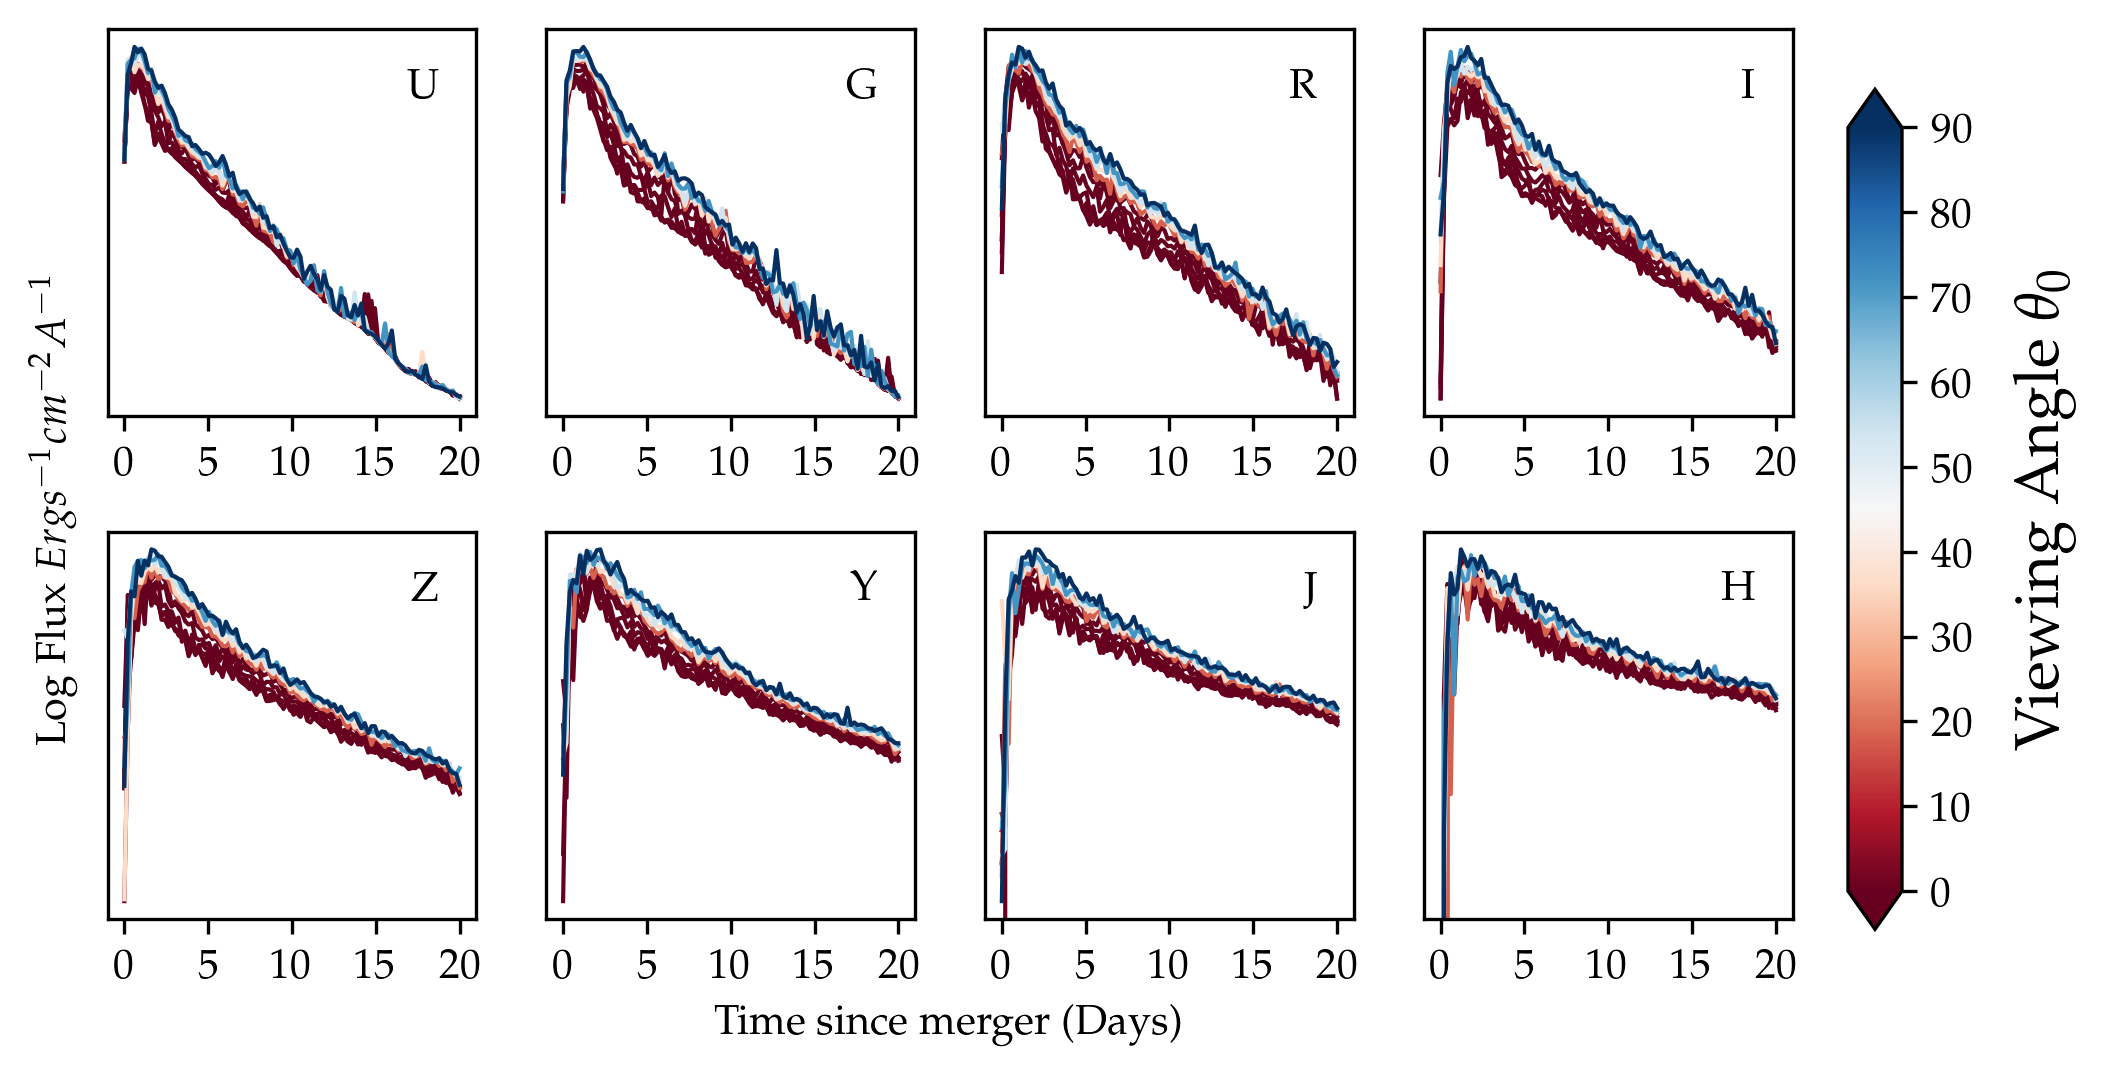

In [33]:
# # Selecting a singular light curve

data = LightCurve("reference.csv")
phi_range = [30]
mejdyn_range = [0.01]
mejwind_range = [0.11]
# data.select_curve(phiRange = phi_range, 
#                   mejdynRange = mejdyn_range, 
#                   mejwindRange = mejwind_range)
# data.selected
# zBand = 900.0
# data.extract_curve()
# data.curve.head(2) # iobs goes from 0 --> 10 (11 rows)
# data.simple_plot(zBand)
# data.plot_viewingangle_simple()
data.select_viewingangle(phi_range, mejdyn_range, mejwind_range)
data.plot_viewingangle()

Plot is based on viewing angle. The plot is also general for any wavelength. 

In [61]:
# # FIXED EJECTA MASS DYNAMIC
# data = LightCurve("reference.csv")

# mejdyn_range_list = data.reference.mejdyn.unique()
# mejdyn_range_list = [[x] for x in mejdyn_range_list]
# df = pd.DataFrame()
# wv_range = [900]
# iobs_range = [0]
# phi_range = [45]
# mejwind_range = [0.13]
# data.select_curve(phiRange = phi_range, mejwindRange = mejwind_range)
# tempReference = data.selected

# for i in range(len(mejdyn_range_list)):
#     mejdyn_range = mejdyn_range_list[i]
#     data.select_curve(mejdynRange = mejdyn_range)
#     data.extract_curve()
#     arr = data.curve[data._compute_wavelength(wv_range[0])][iobs_range[0]] # at wv 900, iobs0, over TIME STEP, for mejdyn 0.01
#     assert len(arr) == data.Ntime[0]
#     df[mejdyn_range_list[i][0]] = arr
#     data.selected = tempReference

# df.columns.name = "mejdyn"
# df.index.name = "time_step"
# df

[[0.001], [0.01], [0.005], [0.02]]


mejdyn,0.001,0.010,0.005,0.020
time_step,,,,
0,0.000711,0.000001,0.000002,0.000003
1,0.000324,0.000513,0.000648,0.001557
2,0.000559,0.001720,0.000360,0.001666
3,0.001292,0.002230,0.004094,0.003742
4,0.000506,0.001995,0.001274,0.002385
...,...,...,...,...
95,0.000032,0.000017,0.000028,0.000013
96,0.000031,0.000021,0.000023,0.000013
97,0.000023,0.000019,0.000029,0.000011


In [75]:
# # FIXED EJECTA MASS WIND
# data = LightCurve("reference.csv")
# mejwind_range_list = data.reference.mejwind.unique()
# mejwind_range_list = [[x] for x in mejwind_range_list]
# df = pd.DataFrame()
# wv_range = [900]
# iobs_range = [0]
# mejdyn_range = [0.01]
# phi_range = [45]
# data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range)
# tempReference = data.selected

# for i in range(len(mejwind_range_list)):
#     mejwind_range = mejwind_range_list[i]
#     data.select_curve(mejwindRange = mejwind_range)
#     data.extract_curve()
#     arr = data.curve[data._compute_wavelength(wv_range[0])][iobs_range[0]] # at wv 900, iobs0, over TIME STEP, for mejdyn 0.01
#     assert len(arr) == data.Ntime[0]
#     df[mejwind_range_list[i][0]] = arr
#     data.selected = tempReference

# df.columns.name = "mejwind"
# df.index.name = "time_step"
# df

mejwind,0.13,0.05,0.01,0.09,0.11,0.03,0.07
time_step,,,,,,,
0,0.000001,0.000017,2.729000e-06,0.000001,0.000008,0.000005,0.000002
1,0.000513,0.000294,4.609100e-04,0.001076,0.000821,0.000209,0.000848
2,0.001720,0.000909,5.728700e-04,0.003598,0.001215,0.000810,0.000868
3,0.002230,0.002129,1.159900e-03,0.003052,0.002716,0.001746,0.002607
4,0.001995,0.002337,1.232300e-03,0.000963,0.001977,0.002120,0.001840
...,...,...,...,...,...,...,...
95,0.000017,0.000008,1.633300e-07,0.000015,0.000024,0.000003,0.000011
96,0.000021,0.000006,5.878300e-07,0.000013,0.000018,0.000003,0.000010
97,0.000019,0.000006,4.219400e-07,0.000014,0.000016,0.000002,0.000012


In [77]:
# FIXED PHI 
data = LightCurve("reference.csv")
phi_range_list = data.reference.phi.unique()
phi_range_list = [[x] for x in phi_range_list]
df = pd.DataFrame()
wv_range = [900]
iobs_range = [0]
mejdyn_range = [0.01]
mejwind_range = [0.13]

data.select_curve(mejwindRange = mejwind_range, mejdynRange = mejdyn_range)
tempReference = data.selected

for i in range(len(phi_range_list)):
    phi_range = phi_range_list[i]
    data.select_curve(phiRange = phi_range)
    data.extract_curve()
    arr = data.curve[data._compute_wavelength(wv_range[0])][iobs_range[0]] # at wv 900, iobs0, over TIME STEP, for mejdyn 0.01
    assert len(arr) == data.Ntime[0]
    df[phi_range_list[i][0]] = arr
    data.selected = tempReference

df.columns.name = "phi"
df.index.name = "time_step"
df

phi,45,15,75,60,0,90,30
time_step,,,,,,,
0,0.000001,4.447700e-07,0.000004,0.000031,1.748300e-04,0.000001,0.000004
1,0.000513,2.455300e-05,0.000532,0.000187,1.288300e-06,0.000093,0.000364
2,0.001720,1.137300e-03,0.000719,0.001749,6.851400e-04,0.000926,0.001341
3,0.002230,3.076900e-03,0.001643,0.001243,2.221700e-08,0.002629,0.000663
4,0.001995,3.053600e-03,0.006856,0.002977,2.152000e-03,0.004085,0.001496
...,...,...,...,...,...,...,...
95,0.000017,2.433600e-05,0.000024,0.000025,2.935300e-05,0.000021,0.000022
96,0.000021,2.992700e-05,0.000020,0.000021,2.744800e-05,0.000021,0.000019
97,0.000019,2.133900e-05,0.000018,0.000017,2.878000e-05,0.000019,0.000019


==============================================================================================================
# Stable

In [ ]:
gp = GP("reference.csv")
phi_range = [45]
mejdyn_range = [0.01]
mejwind_range = [0.11]
wv = 900
gp.range_select_wavelength(phi_range, mejdyn_range, mejwind_range, wv)
gp.viewingangle

In [ ]:
gp.single_time_step(1) # Want distribution at 1 day
gp.time_sliced
gp.normedDF()
gp.time_sliced_normed

In [ ]:
gp.setXY_viewingangle()
gp.set_kernel(GPy.kern.RBF(input_dim=1, variance = 2, lengthscale=2))
gp.set_model(GPy.models.GPRegression(gp.X, gp.Y, gp.kernel))

In [ ]:
gp.plot_random_draws()

In [ ]:
gp.model_train(verbose = True)

In [ ]:
gp.plot_random_draws(trained = True)
gp.plot_covariance()